In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Set the figure size to (14,6)
plt.rcParams['figure.figsize'] = (14,6)

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Warmup

## 1) Load the Data

In [ ]:
# this is a just an example time series

df = pd.read_csv('arma_process.csv')
df.head()

## 2) Plot the Data

In [ ]:
df.plot()
plt.title('Remainder')
plt.show()

In [ ]:
df.mean()

## Is this data stationary ??

In [ ]:
# apply the augmented Dicky-Fuller stationarity test

# recap: The null hypothesis is that the time series is NOT-stationary
# i.e. a small p value, less than 0.05, means that you have a stationary series

def print_adf(data):
    """ 
    Prints the results of the augmented Dickey Fuller Test
    """
    adf_stats, p, used_lag, n_obs, levels, information_criterion = adfuller(data)
    
    print(f""" 
              adf_stats: {adf_stats}
              p: {p} 
              used lag: {used_lag} 
              number of observations: {n_obs}
            
              CI 99%: {levels['1%']}
              CI 95%: {levels['5%']}
              CI 90%: {levels['10%']}
              information criterion (AIC): {information_criterion}
            """)

In [ ]:
print_adf(df['remainder'])

### We then conclude from the results of the adf test that the time series we have is stationary

## 3) Inspect the Partial Autocorrelation (Box-Jenkins-Methodology)

In [ ]:
# Plot the partial autocorrelation function
plot_pacf(df['remainder']);

plt.show()

In [ ]:
# for later: plot autocorrelation function

#plot_acf(df['remainder']);

## Q: Inspecting the pacf plot we choose to include ? lags into our model ? How can we be additionally sure ?

In [ ]:
# Use ar_select_order - brute force method that tries different models and takes the best one

order = ar_select_order(df, maxlag=20, old_names=False)

In [ ]:
# How many lags does ar_select_order suggest?

order.ar_lags

## 4) Build a AR model with the right number of lags

Everything points us towards using 4 lags for our model

In [ ]:
# Fit a statsmodels AutoReg model
# pure autoregressive model: AR4
ar_model = AutoReg(df['remainder'], lags=4, old_names=False).fit()

In [ ]:
df['remainder']

In [ ]:
ar_model.predict()

In [ ]:
# Plot the prediction

df['remainder'].plot()
plt.plot(ar_model.predict(), label='ar_predictions') # insample prediction
plt.legend()
plt.show()

# Looks good, can we do better?

## ARIMA - Autoregressive Integrated Moving Average

With the AR model we found a quite decent model for our data. The question is, can we do even better? 

One way we might be able to improve our model is by including a **Moving Average part (MA)** into the model, if it exists

Simply speaking the **MA** part is just a different way of modeling time dependence. Instead of using past values of the variable itself we will **use past prediction errors to predict the future**. Mathematically this looks like:

### 1) AR(p)

The $AR(p)$ part is just an autoregressive part of the model where *p* denotes the number of lags to include.

### 2) I(d)

The $I(d)$ part is just the part where the model is detrended. *d* determines which order of differencing should be applied to the original time series data before modelling the AR and MA parts

If the data is stationary, then $d = 0$

### 3) MA(q)

This is the new part that we have not seen before. Instead of regressing on past lags, the Moving Average approach regresses on past errors:

**MA(1):** $\hat{y_{t+1}} = b + \phi*\epsilon_{t}$

where $\epsilon_{t} = \hat{y_{t}} - y_{t} $

or adding more features (lags):

**MA(2):** $\hat{y_{t+1}} = b + \phi_1*\epsilon_{t} + \phi_2*\epsilon_{t-1}$

or adding more features (lags):

**MA(q):** $\hat{y_{t+1}} = b + \phi_1*\epsilon_{t} + ... + \phi_q*\epsilon_{t-q-1}$


### How do we determine the order of the MA term q?

Instead of looking at the partial autocorrelation as was the case for the AR model we can look at the autocorrelation between observations $y_t$ and $y_{t-h}$.

$$
Corr(y_t, y_{t-h}) = \frac{Cov(y_t, y_{t-h})}{\sqrt{V(y_t)*V(y_{t-h})}}
$$

**What does the Box-Jenkins method say here?**

#### Value of q

The value of q is found from the autocorrelations plot as follows:


- If the autocorrelations cut off after a few lags, the last lag with a large value would be the estimated value of q
- If the autocorrelations do not cut off, but rather decay gradually, you either have an autoregressive model (q=0) or an ARIMA model with a positive p and q

[source](https://www.ncss.com/wp-content/themes/ncss/pdf/Procedures/NCSS/The_Box-Jenkins_Method.pdf)

In [ ]:
# let's examine both plots now

plot_pacf(df['remainder']);

In [ ]:
plot_acf(df['remainder']);

Analogous to the plot of the partial autocorrelation for the AR part of the model, the plot of the autocorrelation function gives us an idea which lag to chose for the MA. If there is no clear cutoff this could mean

- That the time series is better modelled by a pure AR model
- That the time series is best modelled by a model including AR and MA terms (ARIMA)

### How to read the ACF-plot and the PACF-plot

Interpretation:

- If the ACF-Plot is showing an exponential and slow decay, and the PACF-Plot shows a drop after a certain lag, we conclude that the data is best modelled by an AR(p) process. p is given by the last meaningful lag in the PACF-Plot.

### **AR process**

ACF-Plot AR(1)             |  PACF-Plot AR(1)
:-------------------------:|:-------------------------:
![](./images/acf_ar.png)   |  ![](./images/pacf_ar.png)

- If the ACF-Plot is showing a drop after a certain lag, and the PACF-Plot shows an exponential and slow decay, we conclude that the data is best modelled by an MA(q) process. q is given by the last meaningful lag in the ACF-Plot.

---

### **MA process**

ACF-Plot MA(1)             |  PACF-Plot MA(1)
:-------------------------:|:-------------------------:
![](./images/acf_ma.png)   |  ![](./images/pacf_ma.png)

- If both the ACF-Plot and the PACF-Plot are showing an exponential and slow decay, we conclude that the data is best modelled by an ARIMA(p,d,q) process. p and q cannot be inferred from the plots. Usually you would use an iterrative approach and try different combinations to find the best model. (eg. https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html)

---

### **ARIMA process**

ACF-Plot ARIMA(1,0,1)      |  PACF-Plot ARIMA(1,0,1)
:-------------------------:|:-------------------------:
![](./images/acf_arima.png)|  ![](./images/pacf_arima.png)

## How do I determine which model to choose?


1. test stationarity
2. plot pacf and acf
3. determine possible ranges for p and q values
4. Fit all possible combinations (p,0,q) models and compare them. 
   Models with lower AIC/BIC score are better at explaining the data we have
    

#### What do AIC and BIC mean ? https://www.youtube.com/watch?v=McEN54l3EPU

## Other option: brute force; run multiple models with several combinations of p and q and choose the best one where best is usuall measured in terms of AIC

In [ ]:
#!pip install pmdarima

In [22]:
from pmdarima.arima import auto_arima

In [ ]:
# ARIMA(p,d,q)

# p = number of AR lags
# q = number of MA lags
# d = the order of integration (if the data is stationary, d=0)

auto_arima_model = auto_arima(df['remainder'], start_p=0, start_q=0, 
                              max_p=15, max_q=15, d=0)


In [ ]:
auto_arima_model

# Integrated(I)

Integrating a time series is an alternative way to model a trend of the time series.

if $y_t$ is our time series and it has a trend component, then to de-trend the series and make it stationary, we can difference it ==> $y_t - y_{t-1}$ would be the time series differentiated by order 1

Then to be able to get $y_t$ from the stationary de-trended series, we would need to **integrate** once, i.e. $I(1)$

In [ ]:
import numpy as np

In [ ]:
df_i = pd.DataFrame({'y': range(101)})
df_i.head()

In [ ]:
df_i.plot()

plt.show()

In [ ]:
df_i.shift()

In [ ]:
# Let's first order differentiate this time series data
df_i['y_diff'] = df_i.y - df_i.y.shift(1) # y_t - y_{t-1}
df_i['y_difference'] = df_i['y'].diff()
df_i.head()

In [ ]:
df_i.plot()

plt.show()

# How to integrate the knowledge into the project ??

In [3]:
PATH = '/home/florianriemann/data_science_portfolio/boot_camp/data/data_temperature/'

In [4]:
# flights_train = pd.read_csv('flights_train.csv', parse_dates=True, index_col=0)
flights_train = pd.read_csv(PATH + 'milk_remainder.csv', index_col = 0, parse_dates = True)

flights_train.head()

,remainder
date,
1975-01-01,61.532982
1975-01-02,70.532961
1975-01-03,45.532939
1975-01-04,58.532917
1975-01-05,72.532894


### Step1: inspect the time series by plotting

- does the series have a trend ?
- does the series have seasonality ?
- is the series stationary ?

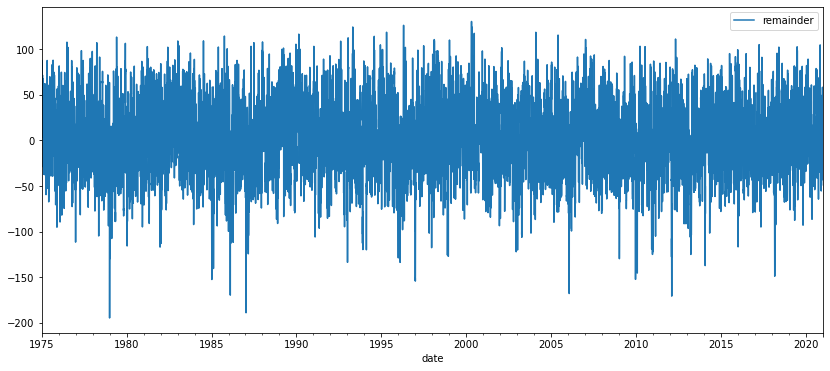

In [5]:

flights_train.plot();

<AxesSubplot:xlabel='date'>

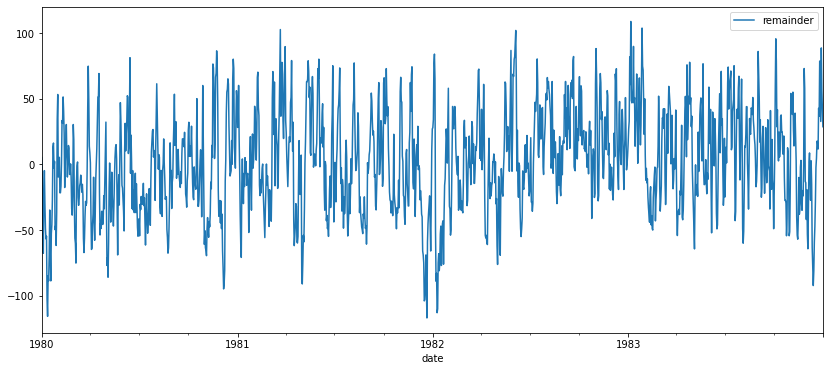

In [7]:
flights_train.loc['1980':'1983'].plot()

In [8]:
### we can already see that there is trend and seasonality in the series, meaning it is non-stationary

test_result=adfuller(flights_train['remainder'])

print('ADF Statistic: %f' % test_result[0])
print('p-value: %f' % test_result[1])

ADF Statistic: -38.207605
p-value: 0.000000


In [9]:
#Ho - null hypothesis: series is non stationary
#H1 - alternative hypothesis: series is stationary

def adfuller_test(series):
    result=adfuller(series)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis, indicating data is non-stationary")

        
adfuller_test(flights_train['remainder'])

ADF Test Statistic : -38.207604747831105
p-value : 0.0
#Lags Used : 3
Number of Observations Used : 16798
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


### Step 2: Make time series stationary

why ?? this enables us to find the right model order (p,d,q) for our series

In [10]:
# what to do if the time seris has a trend ?

flights_train['diff1'] = flights_train['remainder'].diff(1)

flights_train.head()

,remainder,diff1
date,,
1975-01-01,61.532982,NaN
1975-01-02,70.532961,8.999978
1975-01-03,45.532939,-25.000022
1975-01-04,58.532917,12.999978
1975-01-05,72.532894,13.999978


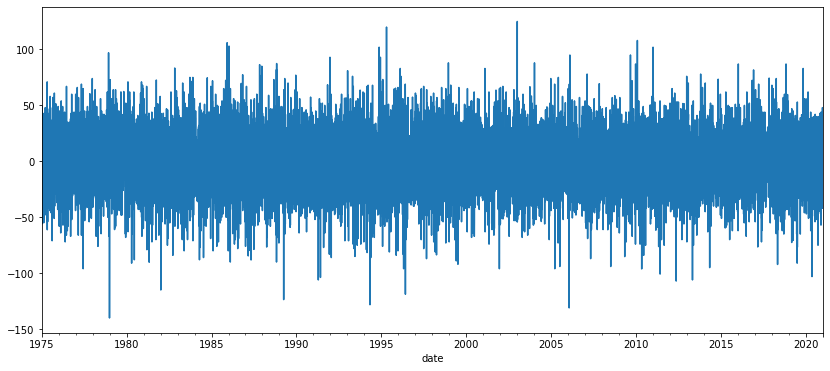

In [11]:
# plot the differenced signal and inspect results of adfuller test

flights_train['diff1'].plot();

In [12]:
adfuller_test(flights_train['diff1'].dropna())

ADF Test Statistic : -29.98915133222817
p-value : 0.0
#Lags Used : 44
Number of Observations Used : 16756
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


#### up till here, we can say that d = 1 and for now ignore the seasonality

### Note 1: Even though the adfuller test p-value is less than 0.05, it is very close to that value. In this case, the reason is that there is seasonality in the time series that we did not yet extract. We will circle back to this in Seasonal ARIMA (SARIMA)

### Note 2: We should use the stationary version of the time series to plot ACF and PACF!!!!

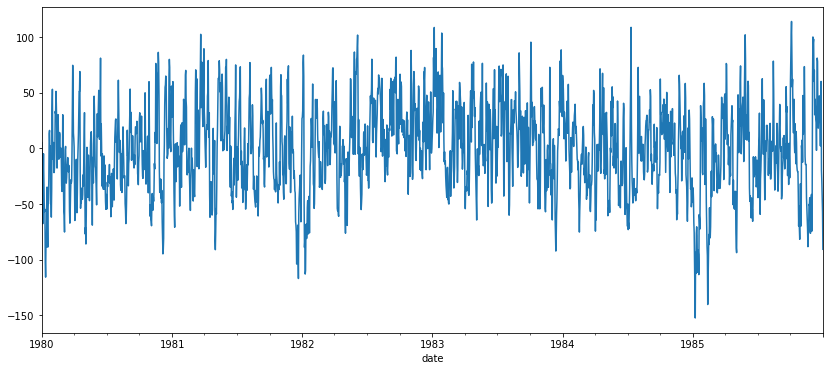

In [13]:
# inspecting the period of seasonality in the data

flights_train['remainder'].loc['1980':'1985'].plot();

**conclusion: there is a period of 12 (12 months of the year) after which the series have the same shape**

In [14]:
## What to do is the series has seasonality ??


## period m=12 is the period of my seasonality

flights_train['seasonal_diff1'] = flights_train['diff1'].diff(12)

flights_train.head(20)

,remainder,diff1,seasonal_diff1
date,,,
1975-01-01,61.532982,NaN,NaN
1975-01-02,70.532961,8.999978,NaN
1975-01-03,45.532939,-25.000022,NaN
1975-01-04,58.532917,12.999978,NaN
1975-01-05,72.532894,13.999978,NaN
1975-01-06,87.532872,14.999978,NaN
1975-01-07,31.532850,-56.000022,NaN
1975-01-08,3.532827,-28.000023,NaN
1975-01-09,21.532804,17.999977,NaN


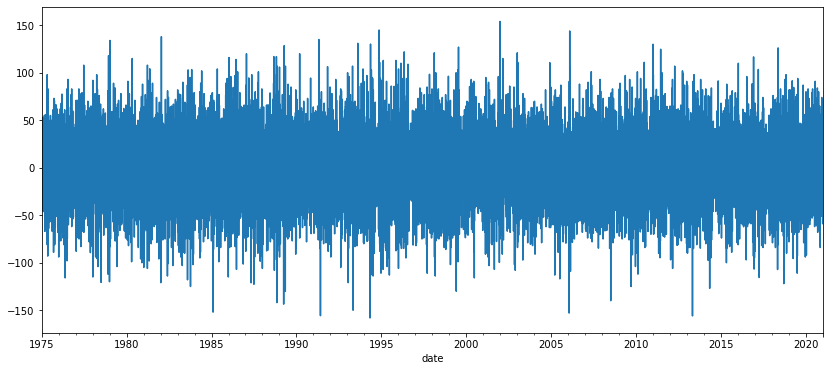

In [15]:
# plot the first seasonal difference 

flights_train['seasonal_diff1'].plot();

In [16]:
# check results of adfuller test

adfuller_test(flights_train['seasonal_diff1'].dropna())

ADF Test Statistic : -33.483824427044894
p-value : 0.0
#Lags Used : 44
Number of Observations Used : 16744
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


### step 3: Let's look at the acf and pacf plots (of the stationary differenced data)

#### A: checking only the detrended data

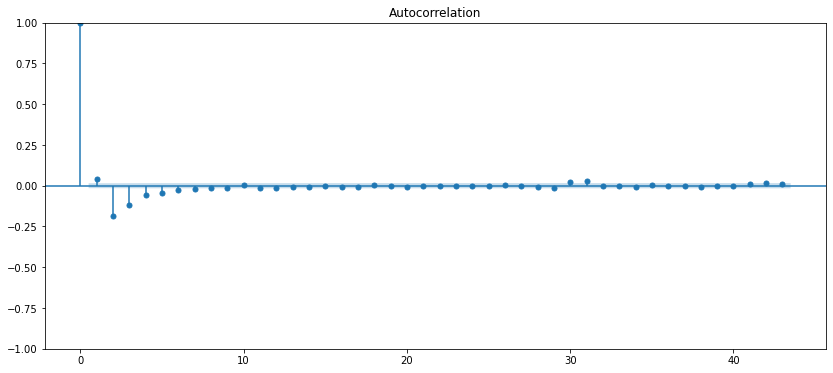

In [17]:
plot_acf(flights_train['diff1'].dropna());

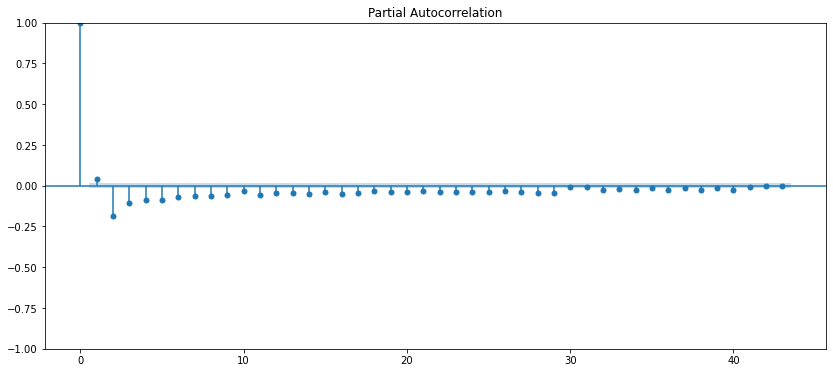

In [18]:
plot_pacf(flights_train['diff1'].dropna());

#### checking the seasonal differenced series (trend and seasonality both taken out)

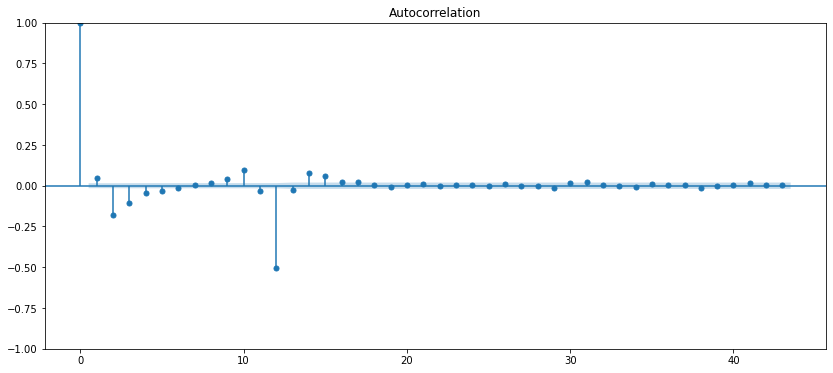

In [19]:
plot_acf(flights_train['seasonal_diff1'].dropna());

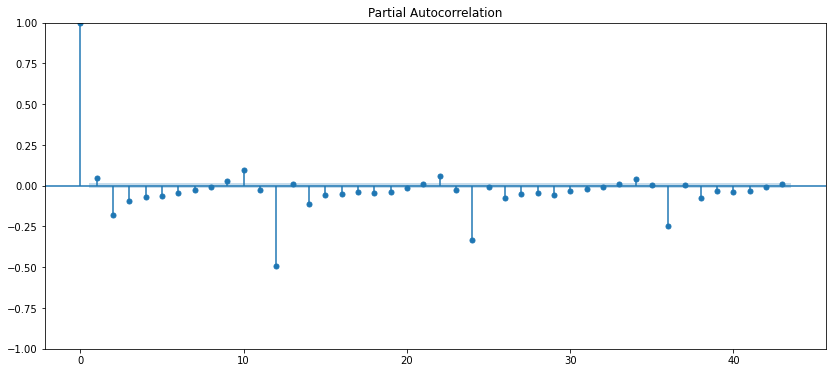

In [20]:
plot_pacf(flights_train['seasonal_diff1'].dropna());

### step 4: Attempt multiple models and choose the best

#### we will ignore the seasonality now and go with an ARIMA model that does not take seasonality in consideration

In [23]:
from pmdarima.arima import auto_arima

In [24]:
auto_arima_model = auto_arima(flights_train['remainder'], 
                              start_p=0, start_q=0, 
                              max_p=15, max_q=15, max_d=2)

In [25]:
auto_arima_model

ARIMA(order=(3, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [26]:
# fit and ARIMA (3,1,4) model (p,d,q)

model = ARIMA(flights_train['remainder'], order=(3,0,1)).fit()

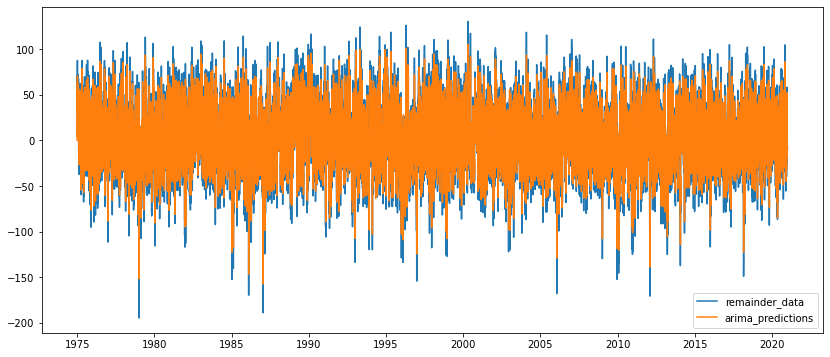

In [27]:
plt.plot(flights_train['remainder'], label='remainder_data')
plt.plot(model.predict(), label='arima_predictions')  # this is called in-sample predictions, predictions on test data
plt.legend();

In [29]:
# calculate rmse on training data
import numpy as np
rmse_no_seasonality = np.sqrt(mean_squared_error(flights_train['remainder'], model.predict()))

rmse_no_seasonality

22.87280303485499

## so how can we check model behavior on unseen data ? How can we use the model to forecast ?

In [30]:
flights_train.tail()

,remainder,diff1,seasonal_diff1
date,,,
2020-12-27,-18.881175,5.99759,1.999998
2020-12-28,-6.883585,11.99759,-11.000002
2020-12-29,-11.885995,-5.00241,19.999998
2020-12-30,-9.888405,1.99759,2.999998
2020-12-31,-8.890815,0.99759,25.999998


### a) One step out-of-sample prediction

In [31]:
model.forecast()

2021-01-01   -7.106067
Freq: D, dtype: float64

### b) Multiple steps out-of-sample predictions

In [33]:
model.predict(start='2021-01-01', end='2021-12-01')

2021-01-01   -7.106067
2021-01-02   -5.560342
2021-01-03   -4.416823
2021-01-04   -3.552331
2021-01-05   -2.864330
                ...   
2021-11-27    0.001025
2021-11-28    0.001025
2021-11-29    0.001025
2021-11-30    0.001025
2021-12-01    0.001025
Freq: D, Name: predicted_mean, Length: 335, dtype: float64

In [ ]:
flights_test = pd.read_csv('flights_test.csv', parse_dates=True, index_col=0)


In [ ]:
flights_test

In [ ]:
# add predictions from both models

flights_test['arima_predictions'] = model.predict(start='1960-01-01', end='1960-12-01').values

In [ ]:
flights_test

In [ ]:
plt.plot(flights_test['passengers'], label='passenger_data')
plt.plot(flights_test['arima_predictions'], label='arima predictions -- no seasnonality')
plt.legend();

In [ ]:
test_rmse_no_seasonality = np.sqrt(mean_squared_error(flights_test['passengers'], flights_test['arima_predictions']))

test_rmse_no_seasonality

In [ ]:
### introducing SARIMAX to handle seasonailty and hopefully get a better model (measure by rmse on test data)

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# the seasonal arima has 7 different hyperparameters: (p,d,q)(P,D,Q,m)
# m here is the series period, which we know is 12
# we can also use auto_arima to help us identify the best model


auto_arima_model = auto_arima(flights_train['passengers'], start_p=0, start_q=0, max_p=10, max_q=10, max_d=2, 
                              seasonal=True, start_P=0, start_Q=0, max_D=2, m=12, max_P=10, max_Q=10,
                              trace=True)

In [ ]:
auto_arima_model

In [ ]:
sarima_model = SARIMAX(flights_train['passengers'], 
                       order=(2,0,0), seasonal_order=(3,1,0,12)).fit()

In [ ]:
# calculate train error

rmse_sarima = np.sqrt(mean_squared_error(flights_train['passengers'], 
                                         sarima_model.predict()))

In [ ]:
rmse_sarima

In [ ]:
plt.plot(flights_train['passengers'], label='passenger_data')
plt.plot(sarima_model.predict(), label='sarima predictions')
plt.plot(model.predict(), label='arima predictions')
plt.legend()

plt.show()

In [ ]:
# to compare correctly, drop the first period (12 months) of both predictions

rmse_no_seasonality = np.sqrt(mean_squared_error(flights_train['passengers'].loc['1950':'1959'],
                                                model.predict().loc['1950':'1959']))

rmse_sarima = np.sqrt(mean_squared_error(flights_train['passengers'].loc['1950':'1959'],
                                                sarima_model.predict().loc['1950':'1959']))

print(rmse_no_seasonality, rmse_sarima)

In [ ]:
flights_test['sarima_predictions'] = sarima_model.predict(start='1960-01-01', end='1960-12-01')

plt.plot(flights_test['passengers'], label='passenger_data')
plt.plot(flights_test['sarima_predictions'], label='sarima predictions')
plt.plot(flights_test['arima_predictions'], label='arima predictions')
plt.legend()

plt.show()